In [200]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [201]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [202]:
NUM_CLASSES = 28

# Dataset reading

In [203]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [204]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [206]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [207]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_22 (Dropout)        (None, 42)                0         
                                                                 
 dense_33 (Dense)            (None, 20)                860       
                                                                 
 dropout_23 (Dropout)        (None, 20)                0         
                                                                 
 dense_34 (Dense)            (None, 10)                210       
                                                                 
 dense_35 (Dense)            (None, 28)                308       
                                                                 
Total params: 1,378
Trainable params: 1,378
Non-trainable params: 0
_________________________________________________________________


In [208]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [209]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [210]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


26/37 [====================>.........] - ETA: 0s - loss: 3.2840 - accuracy: 0.1154 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
37/37 [==============================] - 1s 7ms/step - loss: 3.2678 - accuracy: 0.1216 - val_loss: 3.1678 - val_accuracy: 0.1352
Epoch 2/1000
27/37 [====================>.........] - ETA: 0s - loss: 3.1628 - accuracy: 0.1571
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
37/37 [==============================] - 0s 4ms/step - loss: 3.1453 - accuracy: 0.1578 - val_loss: 3.0122 - val_accuracy: 0.1333
Epoch 3/1000
28/37 [=====================>........] - ETA: 0s - loss: 3.0126 - accuracy: 0.1836
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
37/37 [==============================] - 0s 4ms/step - loss: 2.9973 - accuracy: 0.1806 - val_loss: 2.8184 - val_accuracy: 0.1784
Epoch 4/1000
27/37 [====================>.........] - ETA: 0s - loss: 2.8440 - accuracy: 0.1976
Epoch 4: savi

In [211]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

13/13 [==============================] - 0s 2ms/step - loss: 0.2568 - accuracy: 0.9537


In [212]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [213]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 54ms/step
[1.5944076e-07 1.6505203e-06 5.1764886e-07 1.4184908e-12 1.2053047e-05
 4.4513858e-11 1.0114128e-08 1.2336687e-07 2.2274726e-06 2.2916972e-10
 1.3332425e-07 9.9617141e-01 4.8213321e-13 1.3035421e-07 1.2763260e-08
 6.8037434e-07 7.2608282e-06 3.1188784e-12 2.6142024e-04 3.8465366e-08
 5.8132574e-15 2.1459247e-15 1.2811213e-15 2.1393394e-09 2.8150268e-06
 3.5389408e-03 2.4080013e-08 3.9211892e-07]
11


# Confusion matrix

50/50 [==============================] - 0s 1ms/step


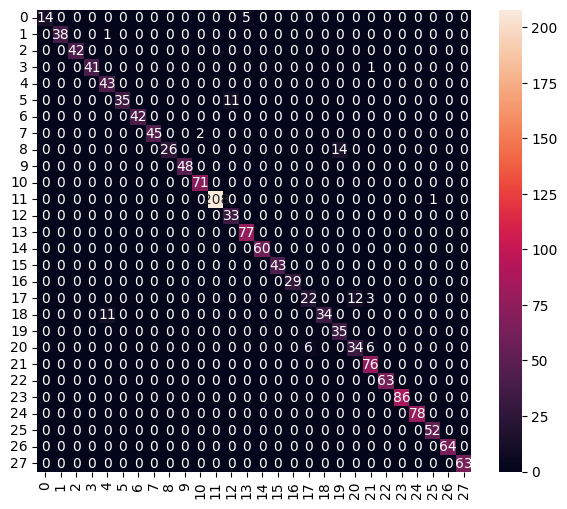

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        19
           1       1.00      0.97      0.99        39
           2       1.00      1.00      1.00        42
           3       1.00      0.98      0.99        42
           4       0.78      1.00      0.88        43
           5       1.00      0.76      0.86        46
           6       1.00      1.00      1.00        42
           7       1.00      0.96      0.98        47
           8       1.00      0.65      0.79        40
           9       1.00      1.00      1.00        48
          10       0.97      1.00      0.99        71
          11       1.00      1.00      1.00       209
          12       0.75      1.00      0.86        33
          13       0.94      1.00      0.97        77
          14       1.00      1.00      1.00        60
          15       1.00      1.00      1.00        43
          16       1.00      1.00      1.00        29
     

In [214]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [215]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [216]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\zubin\AppData\Local\Temp\tmp_uqta7fy\assets


INFO:tensorflow:Assets written to: C:\Users\zubin\AppData\Local\Temp\tmp_uqta7fy\assets


7680

# Inference test

In [217]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [218]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [219]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [220]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [221]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.5944046e-07 1.6505186e-06 5.1764880e-07 1.4184935e-12 1.2053035e-05
 4.4513941e-11 1.0114110e-08 1.2336676e-07 2.2274703e-06 2.2917016e-10
 1.3332411e-07 9.9617141e-01 4.8213321e-13 1.3035419e-07 1.2763258e-08
 6.8037428e-07 7.2608213e-06 3.1188841e-12 2.6141971e-04 3.8465366e-08
 5.8132570e-15 2.1459247e-15 1.2811213e-15 2.1393431e-09 2.8150216e-06
 3.5389371e-03 2.4079965e-08 3.9211852e-07]
11
